In [158]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import openpyxl
import nltk
from bs4 import BeautifulSoup
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

import warnings
warnings.filterwarnings('ignore')

In [159]:
import os
os.listdir("../Datasets")

['1.py', 'amazon_reviews.csv', 'IMDB_Dataset.xlsx']

## Step 1: Reading Dataset

In [160]:
review_df = pd.read_csv("../Datasets/amazon_reviews.csv")
review_df.head(4)

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,0,NaN,4.0,No issues.,2014-07-23,138,0,0,0,0,0.0,0.0
1,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0
2,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0
3,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0


In [161]:
review_df.shape

(4915, 12)

In [162]:
review_df.dtypes

Unnamed: 0                int64
reviewerName             object
overall                 float64
reviewText               object
reviewTime               object
day_diff                  int64
helpful_yes               int64
helpful_no                int64
total_vote                int64
score_pos_neg_diff        int64
score_average_rating    float64
wilson_lower_bound      float64
dtype: object

In [163]:
review_df.describe()


,Unnamed: 0,overall,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
count,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000
mean,2457.000000,4.587589,437.367040,1.311089,0.210376,1.521465,1.100712,0.075468,0.020053
std,1418.982617,0.996845,209.439871,41.619161,4.023296,44.123095,39.367949,0.256062,0.077187
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-130.000000,0.000000,0.000000
25%,1228.500000,5.000000,281.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2457.000000,5.000000,431.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3685.500000,5.000000,601.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4914.000000,5.000000,1064.000000,1952.000000,183.000000,2020.000000,1884.000000,1.000000,0.957544


In [164]:
review_df.isnull().sum()

Unnamed: 0              0
reviewerName            1
overall                 0
reviewText              1
reviewTime              0
day_diff                0
helpful_yes             0
helpful_no              0
total_vote              0
score_pos_neg_diff      0
score_average_rating    0
wilson_lower_bound      0
dtype: int64

## Step 2. Removing null values from dataframe

In [165]:
review_df.shape

(4915, 12)

In [166]:
review_df.dropna(inplace=True)

In [167]:
review_df.shape

(4913, 12)

## Step 3. Remove Unwanted features

In [168]:
review_df.drop(columns=['Unnamed: 0'],axis=1,inplace=True)
review_df = review_df.sort_values(ascending=False,by='wilson_lower_bound')
review_df = review_df.reset_index(drop=True)
review_df.head(4)

,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,"Hyoun Kim ""Faluzure""",5.0,[[ UPDATE - 6/19/2014 ]]So my lovely wife boug...,2013-01-05,702,1952,68,2020,1884,0.966337,0.957544
1,NLee the Engineer,5.0,I have tested dozens of SDHC and micro-SDHC ca...,2012-09-26,803,1428,77,1505,1351,0.948837,0.936519
2,SkincareCEO,1.0,NOTE: please read the last update (scroll to ...,2013-05-08,579,1568,126,1694,1442,0.925620,0.912139
3,"Amazon Customer ""Kelly""",1.0,"If your card gets hot enough to be painful, it...",2012-02-09,1033,422,73,495,349,0.852525,0.818577


In [169]:
review_df['overall'].value_counts()

overall
5.0    3921
4.0     526
1.0     244
3.0     142
2.0      80
Name: count, dtype: int64

In [170]:
review_df_final = review_df[['overall','reviewText','wilson_lower_bound']]
review_df_final.head(3)

,overall,reviewText,wilson_lower_bound
0,5.0,[[ UPDATE - 6/19/2014 ]]So my lovely wife boug...,0.957544
1,5.0,I have tested dozens of SDHC and micro-SDHC ca...,0.936519
2,1.0,NOTE: please read the last update (scroll to ...,0.912139


In [171]:
# python -m spacy download en_core_web_sm


## Step 4: Pre Process (Removing Noise Data)

# Explanation of below Pre Process Function:
    * Stop Words: Words like "is", "for", etc., will be removed since they are in the stopword list.
    * Punctuation: Tokens like "#", "@", ".", "<", ">" are removed since they are punctuation.
    * Digits: Tokens like "99" and "34working" are removed because they contain numbers.
    * Case-insensitive Uniqueness: The function ensures words like "Bye" and "bye" are considered the same and are only kept once.
    * Lemmatization: The words are lemmatized to their base form to make sure variations like "working" and "work" are treated consistently.

In [172]:
import string
import nltk
import spacy


# Load SpaCy model (use 'en_core_web_sm' for English)
nlp = spacy.load('en_core_web_sm')
stop_words = nltk.corpus.stopwords.words('english')

def pre_process(txt):
    tokens = nlp(txt)
    existed_tokens =set()
    filtered_tokens =[]

    # Filter out:
    # 1. Punctuation
    # 2. Digits or alphanumeric tokens
    # 3. Tokens containing non-alphabetic characters (e.g., Hello@, 34working)
    # 4. Ensure case-insensitive uniqueness based on lemmatization
    # 4. Stop words

    for token in tokens:
        # Lemmatize the token and convert to lowercase for uniformity
        lemmatized_word = token.lemma_.lower()
        if lemmatized_word not in existed_tokens and \
                token.text not in string.punctuation  and \
                not token.is_digit and \
                token.text.isalpha() and \
                token.text.lower() not in stop_words:
            
            filtered_tokens.append(token.text)
            existed_tokens.add(lemmatized_word) # Track lemmatized word to ensure uniqueness
    
    return filtered_tokens

In [173]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [174]:
pre_process("If # everything Hello@ everyone . Bye 99 is 34working correctly, < this testing in hospital for patient >  bye> EveryOne")

['everything',
 'everyone',
 'Bye',
 'correctly',
 'testing',
 'hospital',
 'patient']

## Now lets apply above Pre Process function on Reviews Dataset

In [175]:
review_df_final.dtypes

overall               float64
reviewText             object
wilson_lower_bound    float64
dtype: object

In [176]:
review_df_final['reviewText_after_general_pre_process'] =review_df_final['reviewText'].apply(pre_process)

## Build another way of Pre Process function with pre trained BERT Tokenizer

In [177]:
'''
Below function purpose is same as above pre process function however we are using Bert Tokenizer Model which is useful for large dataset
and also improve performance
'''

from transformers import BertTokenizer
import nltk

# Load the pre-trained BERT tokenizer once
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
stop_words_list = nltk.corpus.stopwords.words('english')

def pre_process_with_bert(text):
    # Tokenize into sub words
    tokens = tokenizer.tokenize(text)

    # Remove stop words and punctuation and numbers in one go
    tokens =[token.strip() for token in tokens if token not in stop_words_list and \
                                                  token not in string.punctuation and \
                                                         token.isalpha() and \
                                                        not token.isdigit()
                                                        ]
 
    
    return tokens

In [178]:
pre_process_with_bert("If # everything working Hello@ everyone . Bye 99 is 34working correctly, < this testing in hospital for patient >  bye> EveryOne")

['everything',
 'working',
 'hello',
 'everyone',
 'bye',
 'correctly',
 'testing',
 'hospital',
 'patient',
 'bye',
 'everyone']

In [179]:
review_df_final['reviewText_after_bert_pre_process'] = review_df_final['reviewText'].apply(pre_process_with_bert)

In [180]:
review_df_final.head()

,overall,reviewText,wilson_lower_bound,reviewText_after_general_pre_process,reviewText_after_bert_pre_process
0,5.0,[[ UPDATE - 6/19/2014 ]]So my lovely wife boug...,0.957544,"[UPDATE, lovely, wife, bought, Samsung, Galaxy...","[update, lovely, wife, bought, samsung, galaxy..."
1,5.0,I have tested dozens of SDHC and micro-SDHC ca...,0.936519,"[tested, dozens, SDHC, micro, cards, One, dist...","[tested, dozens, sd, micro, sd, cards, one, di..."
2,1.0,NOTE: please read the last update (scroll to ...,0.912139,"[NOTE, please, read, last, update, scroll, bot...","[note, please, read, last, update, scroll, bot..."
3,1.0,"If your card gets hot enough to be painful, it...",0.818577,"[card, gets, hot, enough, painful, defective, ...","[card, gets, hot, enough, painful, defective, ..."
4,5.0,Sandisk announcement of the first 128GB micro ...,0.808109,"[Sandisk, announcement, first, GB, micro, SD, ...","[sand, announcement, first, micro, sd, took, i..."


## Step 5: Initialize and Train Word2Vec Model

## Pre Processing is completed, now its time to create Vector 
### In this case, we are using word2vec model for creating embedding.


In [181]:
from gensim.models import Word2Vec

# Now, train the Word2Vec model on the list of tokenized sentences
word2vec_model = Word2Vec(sentences=review_df_final['reviewText_after_bert_pre_process'],
                           vector_size=100,  # size of the word vectors
                           window=5,         # the maximum distance between a target word and its context word
                           min_count=2,      # ignore words with a total frequency lower than this
                           workers=4)        # number of CPU cores to use for training


In [182]:

# Save the model for future use
word2vec_model.save("word2vec_model")

In [183]:
word2vec_model.wv.most_similar('update',topn=5)

[('last', 0.9987607002258301),
 ('days', 0.998735249042511),
 ('getting', 0.9985717535018921),
 ('contact', 0.9985030293464661),
 ('found', 0.9984688758850098)]

In [184]:
# Get the list of words in the vocabulary
vocab_list = list(word2vec_model.wv.index_to_key)
print('total words ',len(vocab_list))
print('vocab shape is ',word2vec_model.wv['update'].shape)
vocab_vector = [word2vec_model.wv[vocab] for vocab in vocab_list]
print('each vocab dimension size is ',len(vocab_vector[0]))
print('total vectors len ',len(vocab_vector))


total words  3527
vocab shape is  (100,)
each vocab dimension size is  100
total vectors len  3527


## Step 6: Create Sentence Vector

### Why create sentence vectors?
    * The reason for creating sentence vectors is to represent the entire sentence as a single, fixed-length vector. Word embeddings (like the ones learned by Word2Vec) represent individual words, but they don't provide an immediate way to understand the meaning of an entire sentence.
    * Here's the flow:

        ** Word2Vec Model: Each word in your vocabulary has a corresponding vector representation.
        ** Sentence Vector: A sentence is composed of multiple words. Therefore, the sentence vector can be computed by averaging (or performing other aggregation methods) the word vectors of all words in the sentence.
### Do you need to create sentence vectors?
    * Yes, you still need to create sentence vectors if your goal is to represent an entire sentence as a feature for downstream tasks (like sentiment analysis). The Word2Vec model provides word-level embeddings, but for most machine learning tasks, you need a single vector to represent a sentence. Simply using Word2Vec directly on review_df_final['reviewText_after_bert_pre_process'] would give you word embeddings, but not sentence embeddings.

    * The below function get_sentence_vector created is computing the sentence vector by averaging the word vectors for each word in the sentence. This is a common technique known as **"mean pooling"** or "average word vectors", and it allows you to summarize the semantic meaning of a sentence in a fixed-length vector, which can then be used for classification or other tasks.

### Is it necessary to average the word vectors?
    * Yes, because Word2Vec learns word-level representations, so when you want to use a Word2Vec model for a sentence, you need to aggregate the word vectors. There are several ways to do this, but the simplest and most commonly used approach is averaging the word vectors for all the words in the sentence, which is exactly what you're doing with np.mean(word_vectors, axis=0).

In [185]:
def get_sentence_vector(tokens,model):
    word_vectors = [model.wv[token] for token in tokens if token in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(100)
    
    return np.mean(word_vectors,axis=0)

In [186]:
review_df_final['sentence_vector'] = review_df_final['reviewText_after_bert_pre_process'].apply(lambda tkn:get_sentence_vector(tkn,word2vec_model))


In [187]:
print(review_df_final['sentence_vector'][0].shape)


(100,)


### Step 6.a Convert sentence Vectors to numpy array for PCA

In [188]:
review_df_final.count()

overall                                 4913
reviewText                              4913
wilson_lower_bound                      4913
reviewText_after_general_pre_process    4913
reviewText_after_bert_pre_process       4913
sentence_vector                         4913
dtype: int64

In [189]:
X = np.array(review_df_final['sentence_vector'].tolist())
print(X[0].shape)
X.shape

(100,)


(4913, 100)

## Step 6 b: Dimension Reduction using PCA
    * Using PCA to reduce the dimensionality of the word vectors from 100 dimensions to 50. 
	

In [190]:
pca = PCA(n_components=50,random_state=42)
pca


PCA(n_components=50, random_state=42)

In [191]:
len(vocab_vector) # Total Vocabulary

3527

In [192]:
vocab_vector_pca = pca.fit_transform(X)
print(vocab_vector_pca.shape)
print(vocab_vector[0][:5]) # Original 100 Dimension Vector
print(vocab_vector_pca[0][:5]) # PCA 3 Dimension Vector


(4913, 50)
[ 0.0245565   0.21433733  0.24490808  0.634866   -0.31016564]
[ 0.34183502 -0.12377417 -0.15154147  0.07471325  0.08797625]


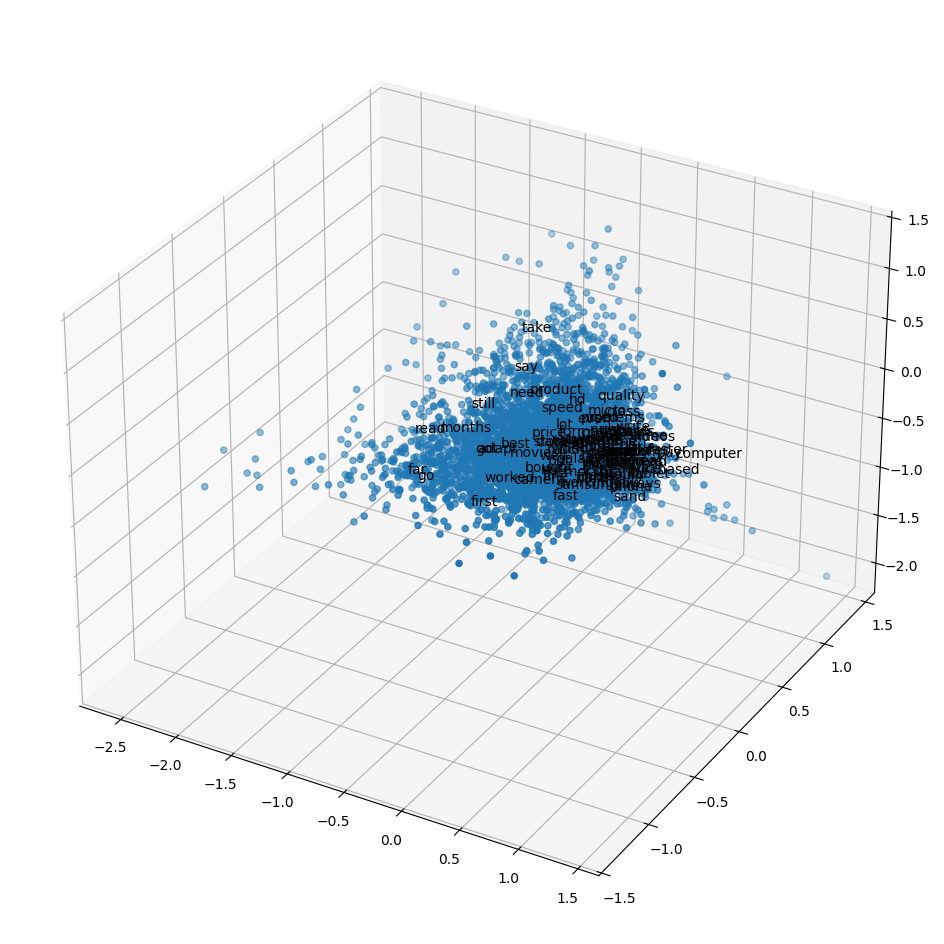

In [193]:
fig = plt.figure(figsize=(16,12))
ax  = fig.add_subplot(projection='3d')

ax.scatter(vocab_vector_pca[:,0],vocab_vector_pca[:,1],vocab_vector_pca[:,2])

for i,word in enumerate(vocab_list[:100]):
    ax.text(vocab_vector_pca[i,0],vocab_vector_pca[i,1],vocab_vector_pca[i,2],word)


## Step 7: Split into Train and Test Data

In [194]:
X = vocab_vector_pca 
#np.vstack(review_df_final['sentence_vector'])
y = review_df_final['overall']
X.shape,y.shape

((4913, 50), (4913,))

In [195]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=0.2)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(3930, 50) (983, 50) (3930,) (983,)


## Step 8: Now Initialize and Build ML Model for Prediction

### 1. Apply Random Forest Method
    * This classifier is a popular machine learning algorithm used for both classification tasks (like sentiment analysis, fraud detection, etc.) and regression tasks. It's based on the Random Forest algorithm, which is an ensemble learning method that combines multiple decision trees to improve the overall performance of the model.

In [196]:
from sklearn.ensemble import RandomForestClassifier
import joblib

rf_classifier = RandomForestClassifier(
    n_estimators=200,            # Number of trees in the forest
    criterion='entropy',         # Using 'entropy' to measure the quality of splits
    max_depth=10,                # Maximum depth of each tree
    min_samples_split=4,         # Minimum number of samples to split an internal node
    min_samples_leaf=2,          # Minimum number of samples at a leaf node
    max_features='sqrt',         # Number of features to consider at each split
    random_state=42,             # For reproducibility
    n_jobs=-1,                   # Use all processors
    oob_score=True               # Use out-of-bag samples to estimate generalization accuracy
)


rf_classifier.fit(X_train,y_train)

# Save the model using joblib
joblib.dump(rf_classifier,'random_forest_model.pkl')


['random_forest_model.pkl']

In [197]:
y_pred_rf = rf_classifier.predict(X_test)
print(y_pred_rf[:5])
print(y_test[:5])
accuracy_rf = accuracy_score(y_test,y_pred_rf)
print(f"accuracy of Random Forest Model is {accuracy_rf:.4f}")

[5. 5. 5. 5. 5.]
2346    5.0
2555    5.0
691     5.0
3908    4.0
2486    5.0
Name: overall, dtype: float64
accuracy of Random Forest Model is 0.8057


## Step 9: Combining all Classifier Models at One go and check accuracy for each one

In [198]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score,classification_report



X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=0.2)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

# Initialize Classifiers

classifiers ={
    'Random Forest':RandomForestClassifier(n_estimators=100,random_state=42),
    'AdaBoost Classifier':AdaBoostClassifier(random_state=42,n_estimators=100),
    'GradientBoosting Classifier':GradientBoostingClassifier(random_state=42,n_estimators=100),
    'SVC':SVC(kernel='linear', random_state=42),
    'Logistic Regression':LogisticRegression(max_iter=1000, random_state=42),
    'MLP Classifier':MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)

}

# Train and Evaluate Each Classifier

results={}
for name,classif in classifiers.items():
    print(f"name is {name} and classifier is {classif}")

    classif.fit(X_train,y_train)
    y_pred = classif.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    results[name]=accuracy

# Print accuracy results
for name,accuracy in results.items():
    print(f"Model name is {name} and its accuracy is {accuracy}")


(3930, 50) (983, 50) (3930,) (983,)
name is Random Forest and classifier is RandomForestClassifier(random_state=42)
name is AdaBoost Classifier and classifier is AdaBoostClassifier(n_estimators=100, random_state=42)
name is GradientBoosting Classifier and classifier is GradientBoostingClassifier(random_state=42)
name is SVC and classifier is SVC(kernel='linear', random_state=42)
name is Logistic Regression and classifier is LogisticRegression(max_iter=1000, random_state=42)
name is MLP Classifier and classifier is MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)
Model name is Random Forest and its accuracy is 0.8067141403865717
Model name is AdaBoost Classifier and its accuracy is 0.7151576805696847
Model name is GradientBoosting Classifier and its accuracy is 0.8046795523906409
Model name is SVC and its accuracy is 0.8067141403865717
Model name is Logistic Regression and its accuracy is 0.8087487283825026
Model name is MLP Classifier and its accuracy is 0.785350

In [199]:
import dagshub
dagshub.init(repo_owner='VenkyJishu', repo_name='MLOPS', mlflow=True)

Initialized MLflow to track repo "VenkyJishu/MLOPS"

Repository VenkyJishu/MLOPS initialized!